<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

**Задача:** Нужно защитить данные клиентов страховой компании «Хоть потоп». Разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score 
import numpy as np 
import seaborn as sns

In [2]:
data = pd.read_csv('/datasets/insurance.csv')

In [3]:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [6]:
data.duplicated().sum()

153

In [7]:
data = data.drop_duplicates() 

<AxesSubplot:xlabel='Пол', ylabel='count'>

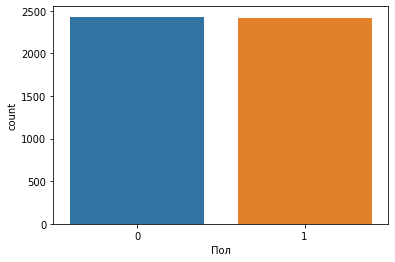

In [8]:
# график распределения пола
sns.countplot(x=data['Пол'])

Оба пола представлены в равной степени.

<AxesSubplot:xlabel='Возраст', ylabel='Count'>

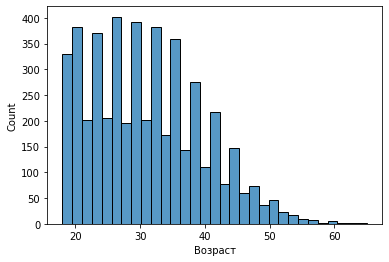

In [9]:
# график распределения возраста
sns.histplot(data['Возраст'])

<AxesSubplot:xlabel='Возраст'>

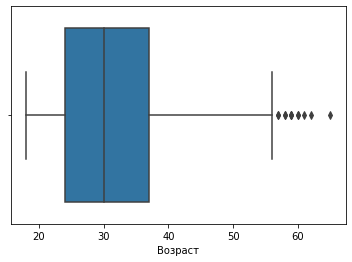

In [10]:
# график размаха возраста
sns.boxplot(x=data['Возраст'])

In [11]:
(data['Возраст'].quantile(.75) - data['Возраст'].quantile(.25))*1.5 + data['Возраст'].quantile(.75)

56.5

Как видно на графике, людей старше 56 лет в выборке значительно меньше.

<AxesSubplot:xlabel='Зарплата', ylabel='Count'>

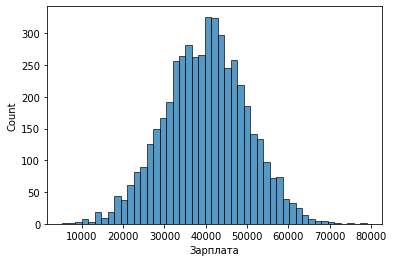

In [12]:
# график распределения зарплаты
sns.histplot(data['Зарплата'])

Красивое нормальное распределение.

<AxesSubplot:xlabel='Зарплата'>

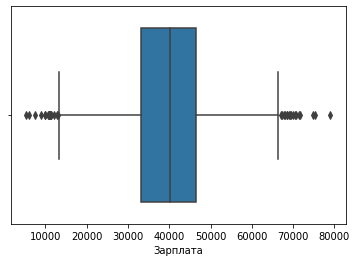

In [13]:
# но на всякий случай график размаха зарплаты
sns.boxplot(x=data['Зарплата'])

In [14]:
data['Зарплата'].mean() - 3 * np.sqrt(np.var(data['Зарплата'], ddof=1))

9976.949888352843

In [15]:
data['Зарплата'].mean() + 3 * np.sqrt(np.var(data['Зарплата'], ddof=1))

69814.67379640062

99% значений лежат в диапазоне от 9900 до 69800.

<AxesSubplot:xlabel='Члены семьи', ylabel='Count'>

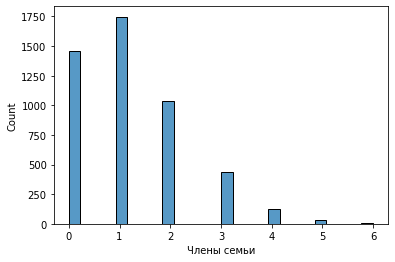

In [16]:
# график распределения количества членов семьи
sns.histplot(data['Члены семьи'])

У большинства 0-2 членов семьи.

<AxesSubplot:xlabel='Страховые выплаты', ylabel='Count'>

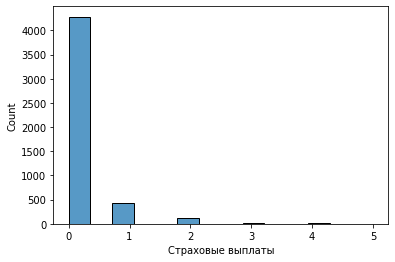

In [17]:
# график распределения количества страховых выплат
sns.histplot(data['Страховые выплаты'])

В большинстве случаев страховые выплаты не потребовались.

## Умножение матриц

Изменится ли качество модели линейной регрессии, если умножить признаки на обратимую матрицу?

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$


**Ответ:** Качество линейной регрессии не должно измениться при умножении признаков на обратимую матрицу.

**Обоснование:**

Матрицу признаков Х умножаем на квадратную случайную обратимую матрицу Р. Полученную матрицу обозначим как Y и подставим в формулу нахождения предсказания:

$$
a = Yw
$$

Также подставим вместо w формулу нахождения веса:

$$
a = Y (Y^T Y)^{-1} Y^T y
$$

Т.к. Y = XP, подставим в формулу это значение:

$$
a = (XP) ((XP)^T (XP))^{-1} (XP)^T y
$$

У матриц есть следующие свойства:

$$
(AB)^T = B^T A^T
$$

И только для квадратных:

$$
(AB)^{-1} = B^{-1} A^{-1} 
$$

Раскроем скобки, воспользовавшись свойствами матриц:

$$
a = (XP)(P^T (X^T X) P)^{-1} P^T X^T y = XP P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y 
$$

Умножение матрицы на обратную матрицу даёт единичную матрицу, а умножение любой матрицы на единичную даёт исходную матрицу. Согласно этим свойствам, сократим полученное выражение и получим:

$$
a = X (X^T X)^{-1} X^T y = Xw
$$

Таким образом, получили исходную формулу.

## Алгоритм преобразования

Для того, чтобы защитить персональные данные клиентов страховой компании, разработаем алгоритм, который умножает матрицу признаков на случайную матрицу.

In [18]:
# алгоритм преобразования
def transform_data(features_train, features_test):
    random_matrix = np.random.normal(size=(4,4))
    try:
        np.linalg.inv(random_matrix)
        transformed_train_data = pd.DataFrame(np.dot(features_train.values, random_matrix))
        transformed_test_data = pd.DataFrame(np.dot(features_test.values, random_matrix))
    except:
        print('Матрица необратима, попробуйте снова')
    
    return transformed_train_data, transformed_test_data 

**Обоснование:** Этот алгоритм должен показать точно такое же качество модели, как и на исходных данных, согласно доказанному на предыдущем шаге свойству об умножении матриц.

## Проверка алгоритма

Для проверки алгоритма обучим модель линейной регрессии на исходных данных и на преобразованных и сравним качество модели метрикой R2.

In [19]:
# разделим выборку на обучающие и целевой признаки
features_train = data.drop('Страховые выплаты', axis=1)
target_train = data['Страховые выплаты']

In [20]:
print(features_train.shape)
print(target_train.shape)

(4847, 4)
(4847,)


In [21]:
# разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(features_train, target_train, test_size=.2, random_state=12345) 

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3877, 4)
(970, 4)
(3877,)
(970,)


Для линейной регрессии необходимо закодировать категориальные признаки и стандартизировать числовые.

In [23]:
# выделим категориальные и числовые признаки
categorical = ['Пол']
numeric = ['Возраст', 'Зарплата', 'Члены семьи']

In [30]:
# инициализация кодировщика
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(X_train[categorical])

OneHotEncoder(drop='first', sparse=False)

In [31]:
# прямое кодирование кат.признаков на обучающей выборке
X_train_encoded = pd.DataFrame(
    encoder.transform(X_train[categorical]),
  #  columns = encoder.get_feature_names_out(categorical)
)

In [38]:
X_train_encoded

,0
0,0.0
1,0.0
2,1.0
3,1.0
4,0.0
...,...
3872,1.0
3873,0.0
3874,1.0
3875,1.0


In [ ]:
# прямое кодирование кат.признаков на тестовой выборке
X_test_encoded = pd.DataFrame(
    encoder.transform(X_test[categorical]),
    columns = encoder.get_feature_names_out(categorical)
)

In [33]:
# обучение scaler
scaler = StandardScaler()
scaler.fit(X_train[numeric])

StandardScaler()

In [34]:
# масштабирование числовых признаков на обучающей выборке
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train[numeric]),
  #  columns = scaler.get_feature_names_out(numeric)
)

In [35]:
# масштабирование числовых признаков на тестовой выборке
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test[numeric]),
  #  columns = scaler.get_feature_names_out(numeric)
) 

In [ ]:
# объединение преобразованных признаков на обучающей выборке
X_train_transformed = X_train_encoded.join(X_train_scaled)
X_train_transformed = X_train_transformed.rename(columns={'Пол_1': 'Пол'})
X_train_transformed.head() 

In [ ]:
# объединение преобразованных признаков на тестовой выборке
X_test_transformed = X_test_encoded.join(X_test_scaled)
X_test_transformed = X_test_transformed.rename(columns={'Пол_1': 'Пол'})
X_test_transformed.head()  

In [129]:
# инициализация модели линейной регрессии
linreg = LinearRegression()

In [130]:
scores = cross_validate(linreg, X_train_transformed, y_train, cv=5, scoring='r2')

In [131]:
scores['test_score'].mean()

0.4304972994250898

In [132]:
linreg.fit(X_train_transformed, y_train)

LinearRegression()

In [133]:
y_pred = linreg.predict(X_test_transformed)

In [134]:
r2_score(y_test, y_pred) 

0.4160549216151216

Теперь обучим модель на преобразованных данных.

In [135]:
X_train_new, X_test_new = transform_data(X_train_transformed, X_test_transformed)

In [136]:
X_train_new.head() 

,0,1,2,3
0,1.912928,1.580611,-0.543088,-0.865169
1,-0.883808,-0.984228,0.412307,1.575855
2,-0.064077,-0.908865,0.408882,2.933352
3,0.905312,2.412909,1.457953,-0.571088
4,-0.765126,-1.832191,-0.655229,1.093537


In [137]:
linreg.fit(X_train_new, y_train)

LinearRegression()

In [138]:
y_pred_new = linreg.predict(X_test_new) 

In [139]:
r2_score(y_test, y_pred_new)

0.41605492161512125

Метрика R2 на исходных и на преобразованных данных одинакова.